In [1]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 80)
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

In [2]:
# read in classified deeds file
rtt_classified = gpd.read_file("data/rtt_investors_classified.geojson")
# read in PHI city limits


In [3]:
# Specify coordinate reference system
rtt_classified.to_crs='epsg:2272'
#rtt_classified.head()

In [4]:
city_limits = gpd.read_file("data/02_flip-investigations_data/Map_Base/PHI_City_Limits.geojson")

In [5]:
city_limits.crs 

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
PHI_city_limits = city_limits.to_crs(2272)

In [7]:
# FILTER FOR ADDRESS / ZIP THAT APPEARS MOST TIMES

topzip = rtt_classified['zip_code'].value_counts() 
topaddress = rtt_classified['street_address_x'].value_counts() 

#topaddress.head(10)
#rtt_investors_topaddress.to_file("data/rtt_investors_topaddress.geojson", driver ='GeoJSON')

topaddress_1000 = topaddress.iloc[:1000]
addresses=topaddress_1000.index
a_list=list(addresses)
#list2 = ['12 HAMILTON CIR,' '3817 POPLAR ST']

#is_top = rtt_test['street_address_x'].isin(a_list)
is_top = rtt_classified['street_address_x'] == '12 HAMILTON CIR'
#is_top = rtt_test['zip_code'] == 19134
rtt_top = rtt_classified[is_top]
#rtt_top['property_count'].mean()
rtt_top['receipt_date'] = pd.to_datetime(rtt_top.receipt_date)
rtt_top.sort_values(by=['receipt_date'])
rtt_top.shape



#rtt_top.to_html('temp.html')

/Users/adamvosburgh/opt/anaconda3/envs/geo-2021/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(35, 76)

In [28]:
# filter for investors
rtt_investors = rtt_classified.loc[rtt_classified['inv'] == 1] 
#rtt_investors.to_file("data/02_flip-investigations_data/rtt_investorsOnly.geojson", driver='GeoJSON')

# filter for occupants

rtt_occ = rtt_classified.loc[rtt_classified['inv'] == 0] 
#rtt_occ.to_file("data/02_flip-investigations_data/rtt_occupantsOnly.geojson", driver='GeoJSON')



rtt_occ.shape


(586113, 76)

In [32]:
#INVESTORS

#CHECK DATETIME AND CLEAN
rtt_investors['receipt_date'] = pd.to_datetime(rtt_investors['receipt_date'])

rtt_investors_sorted = rtt_investors.sort_values(by=['street_address_x','receipt_date'])
inv_resetIndex = rtt_investors_sorted.reset_index()
inv_cleanDF = inv_resetIndex.filter(['id','C_DIG1DESC','C_DIG2DESC','C_DIG3DESC','OBJECTID','YEAR','VACBLDG','adjusted_cash_consideration','adjusted_total_consideration','display_date_x','document_date','document_id','document_type','fair_market_value','grantees_x_x','grantors_x','inv','lat','lng','matched_regmap','multi_invest','occ','owner_occup','property_count','receipt_date','recording_date','reg_map_id','sort_year_x','street_address_x','total_consideration','ward','unit_num','zip_code','geometry'])


#GROUP AND ROLLING DIFFERENCE

inv_beg = (inv_cleanDF.street_address_x != inv_cleanDF.street_address_x.shift(1)) 
inv_cleanDF['deedDiff'] = (inv_cleanDF['receipt_date'] - inv_cleanDF['receipt_date'].where(inv_beg).ffill())/np.timedelta64(1,'D')
rtt_deedDiff_inv = inv_cleanDF

#rtt_deedDiff_inv.to_file("data/02_flip-investigations_data/rtt_deedDiff_inv.geojson", driver='GeoJSON')

# FILTER FOR FLIPS

#first take out 0s

inv_no0 = rtt_deedDiff_inv.loc[rtt_deedDiff_inv['deedDiff'] != 0.0]
#then filter for less than 1.5 years (575 days)
rtt_Flips_inv = inv_no0.loc[inv_no0['deedDiff'] <= 575]

rtt_Flips_inv.to_file("data/02_flip-investigations_data/rtt_Flips_inv.geojson", driver='GeoJSON')


In [33]:
#OCCUPANTS

#CHECK DATETIME AND CLEAN
rtt_occ['receipt_date'] = pd.to_datetime(rtt_occ['receipt_date'])

rtt_occ_sorted = rtt_occ.sort_values(by=['street_address_x','receipt_date'])
occ_resetIndex = rtt_occ_sorted.reset_index()
occ_cleanDF = occ_resetIndex.filter(['id','C_DIG1DESC','C_DIG2DESC','C_DIG3DESC','OBJECTID','YEAR','VACBLDG','adjusted_cash_consideration','adjusted_total_consideration','display_date_x','document_date','document_id','document_type','fair_market_value','grantees_x_x','grantors_x','inv','lat','lng','matched_regmap','multi_invest','occ','owner_occup','property_count','receipt_date','recording_date','reg_map_id','sort_year_x','street_address_x','total_consideration','ward','unit_num','zip_code','geometry'])


#GROUP AND ROLLING DIFFERENCE


occ_beg = (occ_cleanDF.street_address_x != occ_cleanDF.street_address_x.shift(1)) 
occ_cleanDF['deedDiff'] = (occ_cleanDF['receipt_date'] - occ_cleanDF['receipt_date'].where(occ_beg).ffill())/np.timedelta64(1,'D')
rtt_deedDiff_occ = occ_cleanDF

#rtt_deedDiff_occ.to_file("data/02_flip-investigations_data/rtt_deedDiff_occ.geojson", driver='GeoJSON')

# FILTER FOR FLIPS

#first take out 0s
occ_no0 = rtt_deedDiff_occ.loc[rtt_deedDiff_occ['deedDiff'] != 0.0]
#then filter for less than 1.5 years (575 days)
rtt_Flips_occ = occ_no0.loc[occ_no0['deedDiff'] <= 575]

rtt_Flips_occ.to_file("data/02_flip-investigations_data/rtt_Flips_occ.geojson", driver='GeoJSON')


/Users/adamvosburgh/opt/anaconda3/envs/geo-2021/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [34]:
# FLIP STATS

#investor
print(100*(rtt_Flips_inv.size/rtt_classified.size)) 


#occupant
print(100*(rtt_Flips_occ.size/rtt_classified.size)) 

      

0.5174129965266003
2.901764940592778


In [36]:
print(rtt_Flips_inv.size)
print(rtt_Flips_occ.size)
print(rtt_classified.size)

270865
1519070
52349864


<AxesSubplot:>

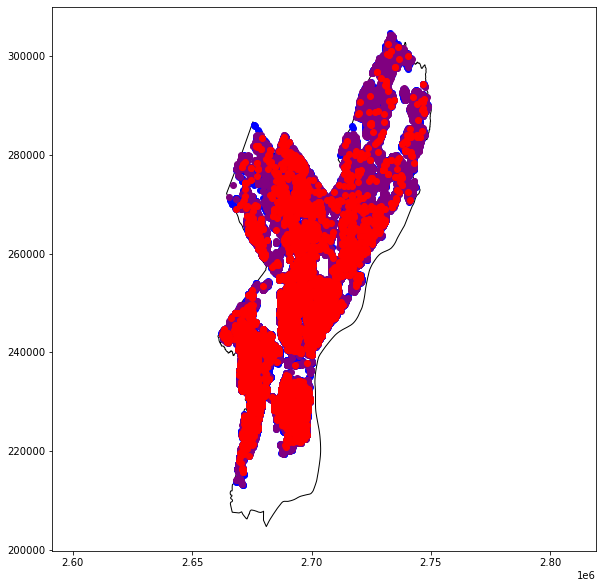

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_box_aspect(aspect=1)

PHI_city_limits.plot(ax=ax, color='white', edgecolor='black')


#rtt_classified.plot(ax=ax, color='blue')
rtt_investors.plot(ax=ax, color = 'blue')
rtt_Flips_occ.plot(ax=ax, color = 'purple')

rtt_Flips_inv.plot(ax=ax, color = 'red')


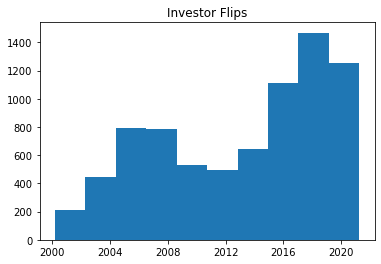

In [48]:
# Investor Flips Histogram
plt.title(label="Investor Flips")
plt.hist(rtt_Flips_inv['receipt_date'])
plt.savefig("data/02_flip-investigations_data/Hist_Investor-Flips.png")


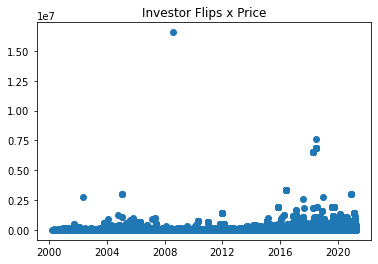

In [54]:
# Investor Flips Scatter
plt.title(label="Investor Flips x Price")
plt.scatter(rtt_Flips_inv['receipt_date'],rtt_Flips_inv['fair_market_value'])
plt.savefig("data/02_flip-investigations_data/Scat_Investor-Flips.png")





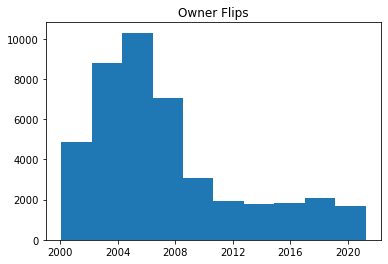

In [47]:
# Owner Flips Histogram
plt.title(label="Owner Flips")
plt.hist(rtt_Flips_occ['receipt_date'])
plt.savefig("data/02_flip-investigations_data/Hist_Owner-Flips.png")


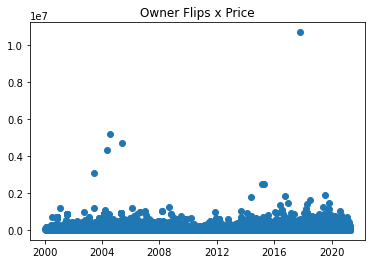

In [52]:
# Owner Flips Scatter

plt.title(label="Owner Flips x Price")
plt.scatter(rtt_Flips_occ['receipt_date'],rtt_Flips_occ['fair_market_value'])
plt.savefig("data/02_flip-investigations_data/Scat_Owner-Flips.png")



In [ ]:
#GRAVEYARD

# check for owner_occ - check is good
#rtt_owner_check = rtt_investors.loc[rtt_investors['owner_occup'] == 1] 
#rtt_owner_check.shape

#_grouped = df.groupby("street_address_x").rolling(window=1).Amount.count()

#rtt_investors_dateindex['flip_time'] = rtt_investors_dateindex.groupby(['street_address_x']).document_date.astype('timedelta64[D]')

#cleanDF['deedDiff'] = cleanDF.groupby(['street_address_x','receipt_date']).receipt_date.apply(lambda x: x - x.iloc[0])
#cleanDF['deedDiff'] /= np.timedelta64 (1, 'D')


#rtt_investors.crs = 'epsg:4326'
#PHI_rtt_investors = rtt_investors.to_crs('epsg:2272')


